In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel(vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [10]:
# 원본 IMDb 데이터셋 다운로드
# import tensorflow as tf
# imdb = tf.keras.datasets.imdb
import os
import numpy as np

import torch
import torch.nn as nn
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# 이번 실습에서는 미리 다운로드된 데이터셋을 불러와 활용하겠습니다
data_dir = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/')

x_train = np.load(data_dir + 'imdb_x_train.npy', allow_pickle=True)
y_train = np.load(data_dir + 'imdb_y_train.npy', allow_pickle=True)
x_test = np.load(data_dir + 'imdb_x_test.npy', allow_pickle=True)
y_test = np.load(data_dir + 'imdb_y_test.npy', allow_pickle=True)
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [13]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([25000, 580])


In [15]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([15000, 580])
(15000,)


In [16]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs_range = 30
epochs = 30   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_307/4288153743.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_307/4288153743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6941, Train Accuracy: 0.4965 - Validation Loss: 0.6931, Validation Accuracy: 0.5053
Epoch 2/30 - Train Loss: 0.6932, Train Accuracy: 0.4965 - Validation Loss: 0.6930, Validation Accuracy: 0.5053
Epoch 3/30 - Train Loss: 0.6930, Train Accuracy: 0.4967 - Validation Loss: 0.6930, Validation Accuracy: 0.5012
Epoch 4/30 - Train Loss: 0.6928, Train Accuracy: 0.5095 - Validation Loss: 0.6930, Validation Accuracy: 0.5012
Epoch 5/30 - Train Loss: 0.6928, Train Accuracy: 0.5007 - Validation Loss: 0.6930, Validation Accuracy: 0.5013
Epoch 6/30 - Train Loss: 0.6926, Train Accuracy: 0.5093 - Validation Loss: 0.6930, Validation Accuracy: 0.5008
Epoch 7/30 - Train Loss: 0.6925, Train Accuracy: 0.5093 - Validation Loss: 0.6930, Validation Accuracy: 0.5009
Epoch 8/30 - Train Loss: 0.6922, Train Accuracy: 0.5093 - Validation Loss: 0.6929, Validation Accuracy: 0.5012
Epoch 9/30 - Train Loss: 0.6920, Train Accuracy: 0.5096 - Validation Loss: 0.6929, Validation Accuracy: 0.5016
E

In [17]:
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.7184, Test Accuracy: 0.5062


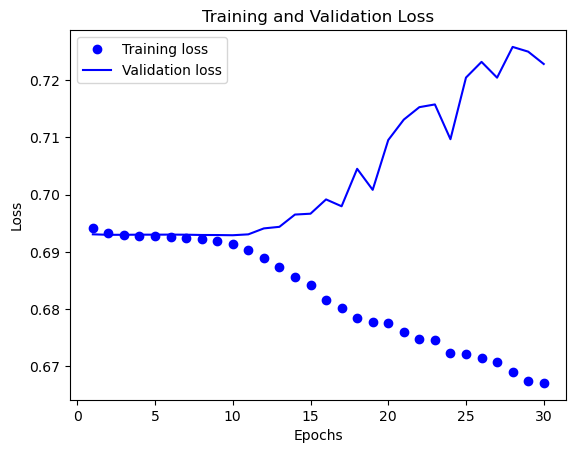

In [18]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

이상한 그래프 뜨시는 분?

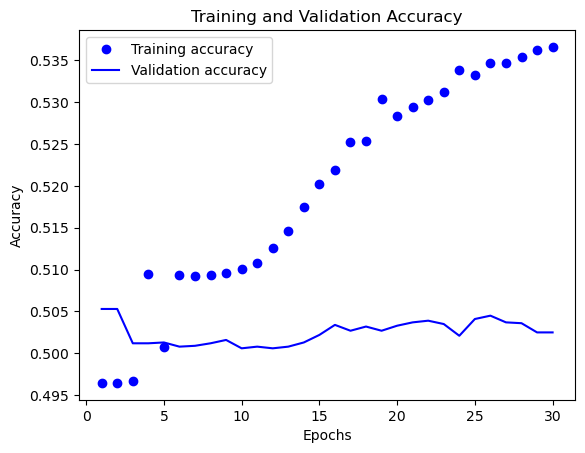

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
embedding_layer = model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
!mkdir ~/work/sentiment_classification/word2vec_emb

mkdir: cannot create directory ‘/home/jovyan/work/sentiment_classification/word2vec_emb’: File exists


In [22]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/word2vec_emb/word2vec.txt')

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

NameError: name 'index_to_word' is not defined

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

In [ ]:
word_vectors.similar_by_word("love")

In [ ]:
from gensim.models import KeyedVectors

word2vec_path = data_dir + 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

In [ ]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수

embedding_matrix = torch.randn(vocab_size, word_vector_dim)

model = SentimentModel(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 학습의 진행
epochs = 20    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # cuda 또는 cpu 출력
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

In [ ]:
# 테스트셋을 통한 모델 평가
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")